<a href="https://colab.research.google.com/github/aherrera3/thesis/blob/main/fits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for the fits of the PDFs and of their parameters

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.odr as odr
from glob import glob
import re
from tqdm import tqdm
from scipy import integrate
from google.colab import files
np.seterr(all="ignore")               # Set how floating-point errors are handled: ignore invalid float operations
plt.rcParams["figure.dpi"] = 130      # Set the resolution to all figures in dots-per-inch
sns.set_style("darkgrid")

In [2]:
!git clone -b "master" --single-branch https://github.com/aherrera3/qcdnum-17-01-14  #"q2_5e8_n_35"

Cloning into 'qcdnum-17-01-14'...
remote: Enumerating objects: 2656, done.
remote: Counting objects: 100% (2656/2656), done.
remote: Compressing objects: 100% (2591/2591), done.
remote: Total 2656 (delta 40), reused 2642 (delta 30), pack-reused 0
Receiving objects: 100% (2656/2656), 12.42 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [3]:
filenames = {}
for fname in glob("qcdnum-17-01-14/output/*"):
    filenames[float(re.search("(?<=_)[\d\.*]+(?=.csv)",fname).group(0))]=fname
pdfnames=pd.read_csv(fname, sep=" ").columns.values[1:]
pdfnames

array(['xuv', 'xdv', 'xubar', 'xdbar', 'xgl'], dtype=object)

In [4]:
pdfnames_latex=['$xu_v$', '$xd_v$', '$x\overline{u}$', '$x\overline{d}$', '$xgl$']
pdfnames_latex

['$xu_v$', '$xd_v$', '$x\\overline{u}$', '$x\\overline{d}$', '$xgl$']

## PDF as function of x

### PDF parametrization function and initial parameters dataframe


In [5]:
# PDFs parametrization
def xpdf_model(B, x):   
    return (1-x)**B[2] * x**B[1] * B[0] * (1 + B[3]*x + B[4]*x**2 + B[5]*np.log(x) + B[6]*np.log(x)**2)

In [6]:
# originals from the paper
initial_parameters = pd.DataFrame({
     'xuv':[10.19304899633023, 0.76,   4.6, 0.0 , 2.6, 0.35  , 0.049],
     'xdv': [5.564255181349489, 0.98,   4.7, 0.0 , 0.0, 0.0   , 0.0],
     'xubar':[    0.14        , -0.33,  11 , 18  , 0.0, 0.071 , 0.0],
     'xdbar':[    0.14        , -0.33,  24 , 38  , 0.0, 0.071 , 0.0],
     'xgl':[0.872978687751462, -0.52,  4.5, 0.0 , 0.0, 0.217 , 0.0112]
},
      index = ["A", "B", "C", "D", "E", "F", "G"]
)
initial_parameters

,xuv,xdv,xubar,xdbar,xgl
A,10.193049,5.564255,0.140,0.140,0.872979
B,0.760000,0.980000,-0.330,-0.330,-0.520000
C,4.600000,4.700000,11.000,24.000,4.500000
D,0.000000,0.000000,18.000,38.000,0.000000
E,2.600000,0.000000,0.000,0.000,0.000000
F,0.350000,0.000000,0.071,0.071,0.217000
G,0.049000,0.000000,0.000,0.000,0.011200


In [7]:
initial_parameters_2={
      'xuv':[1.0, 0.05,   2.0, 4.0 , -6.5, 0.17  , 0.028],
     'xdv': [1.5, 0.003,   6.2, -2.0 , 18.0, 0.2   , 0.02],
     'xubar':[2.092522, 0.146939,6.128849,-2.546240,1.990240,0.307638,0.045121],
     'xdbar':[    4.0        , 0.1,  15 , -3.6  , 5.3, 0.3 , 0.03],
     'xgl':[132.0, 0.52,  11.0, -2.5 , 4.8, 0.48 , 0.06]
}

In [8]:
initial_parameters_3={
      'xuv':[3, 0, 5,  0, 7 , 0.0, 0],
     'xdv': [1.5, 0.003,   6.2, -2.0 , 18.0, 0.2   , 0.02],
     'xubar':[0.1,-0.4,10.6,16,-10,0,0.1,0.0],
     'xdbar':[    4.0        , 0.1,  15 , -3.6  , 5.3, 0.3 , 0.03],
     'xgl':[132.0, 0.52,  11.0, -2.5 , 4.8, 0.48 , 0.06]
}

### Plots of the fitted PDFs

In [9]:
def fit_graphics(x,y,y_fit,title,xlabel,xscale,save,show, label, pdfname):
    # upper graph: the fitsz
    plt.sca(ax[0])                                    # set the current axes to axis=0
    plt.title(r"$Q^2$ = "+ f"{title:.2e}" + " GeV$^2$", fontsize=20)
    if label:
        plt.plot(x, y_fit, c='k', linestyle=(0,(5,5)), label="ODR fit")
    else:
        plt.plot(x, y_fit, c='k', linestyle=(0,(5,5)))
    plt.scatter(x, y, s=3, label=pdfname)
    plt.ylabel("xPDFs", fontsize=15)
    plt.legend()

    # bottom graph: the residuals
    plt.sca(ax[1])                                    # set the current axes to axis=1
    plt.scatter(x, y_fit-y, s=3)
    plt.xlabel(xlabel, fontsize=15)

    #fig.suptitle("Residuals")
    plt.xscale(xscale)
    plt.tight_layout()                                # 
    #plt.savefig(save)
    #plt.show() if show else plt.close()

In [10]:
fitted_betas = {}    # dictionary containing the fitted parameters for every q^2 value and pdfname
column_names=['q_squared','A','B','C','D','E','F','G']

# makes directories 
for pdfname in pdfnames:
    fitted_betas[pdfname]=pd.DataFrame(columns=column_names)
    os.makedirs(f"./img/{pdfname}/Q2", exist_ok=True)

# makes the plots for every fitted pdf
for q_squared in tqdm(sorted(filenames.keys())):
    data=pd.read_csv(filenames[q_squared], sep=" ")

    # figures
    """
    fig, ax = plt.subplots(
        nrows=2,                                # set two horizontal axes
        figsize=(7,7),
        sharex=True,                            # x axis will be shared among all subplots.
        gridspec_kw={"height_ratios":[4,2]}     # different size for upper and bottom axes
    )
    """

    for i, pdfname in enumerate(pdfnames):
        x=data['x']
        y=data[pdfname]
        # fit and beta parameters
        fit=odr.ODR(odr.Data(x, y),
                     odr.Model(xpdf_model),
                     beta0=initial_parameters[pdfname],
                     maxit=5000,
                     ifixx=np.zeros(len(data["x"]))
                     ).run()
        beta=fit.beta 
        row=[q_squared]+list(beta)
        fitted_betas[pdfname]=pd.concat(
            [fitted_betas[pdfname], pd.DataFrame({column_names[i]:[row[i]] for i in range(len(column_names))})])

        """
        if pdfname != "xgl": #if (pdfname == "xubar" or  pdfname == "xdv"): 
            if i==0: fit_graphics(x,y,xpdf_model(beta,x), q_squared,'$x$','log',f"./img/{pdfnames}/Q2/{q_squared}.png",False, True, pdfnames_latex[i])
            else: fit_graphics(x,y,xpdf_model(beta,x), q_squared,'$x$','log',f"./img/{pdfnames}/Q2/{q_squared}.png",False, False, pdfnames_latex[i])
        
        """
        initial_parameters[pdfname]=beta   # the initial parameters are replaced by the new parameters that the program finds.

    #plt.show()        

100%|██████████| 155/155 [00:15<00:00, 10.05it/s]


In [11]:
# fitted_betas is a dictionary, which values are dataframes:
fitted_betas['xdbar']

,q_squared,A,B,C,D,E,F,G
0,2.560000e+00,0.092785,-0.460696,23.196023,37.351243,-1.667274e-08,0.117144,0.002636
0,3.089498e+00,0.088705,-0.473802,23.118118,37.448705,-1.667274e-08,0.121167,0.002938
0,3.728515e+00,0.084806,-0.486635,23.042386,37.583634,-1.667274e-08,0.124960,0.003231
0,4.499704e+00,0.081013,-0.499429,22.969442,37.756511,-1.667274e-08,0.128623,0.003521
0,5.430401e+00,0.077470,-0.511679,22.897781,37.964864,-1.667274e-08,0.131952,0.003788
...,...,...,...,...,...,...,...,...
0,4.523128e+12,0.002241,-1.180112,20.100972,141.728670,-1.667274e-08,0.191479,0.009154
0,5.458671e+12,0.002214,-1.182016,20.097611,142.485180,-1.667274e-08,0.191476,0.009153
0,6.587717e+12,0.002186,-1.183906,20.094356,143.246163,-1.667274e-08,0.191465,0.009150
0,7.950289e+12,0.002160,-1.185776,20.091167,143.980482,-1.667274e-08,0.191464,0.009150


In [12]:
fitted_betas['xubar']['A']

0    0.133151
0    0.132064
0    0.130972
0    0.129826
0    0.128739
       ...   
0    0.029951
0    0.029715
0    0.029478
0    0.029249
0    0.029034
Name: A, Length: 155, dtype: float64

# Parameters

## Graphs of the parameters before fitting

In [13]:
variables = fitted_betas[pdfname].columns.values[1:]

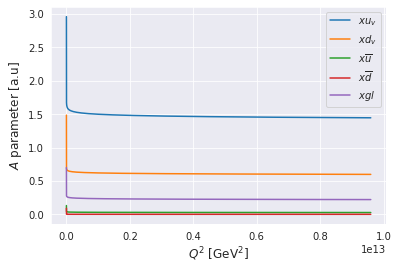

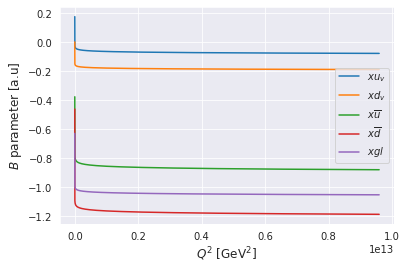

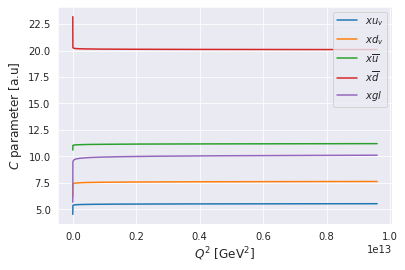

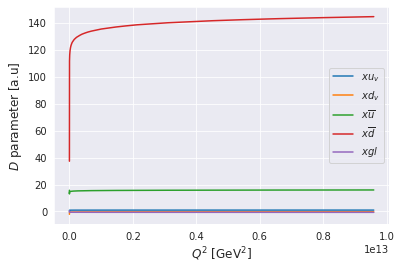

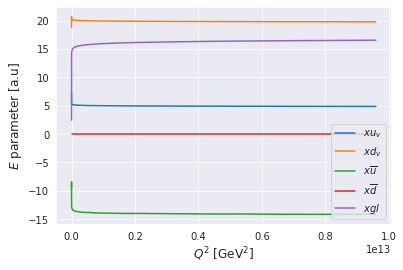

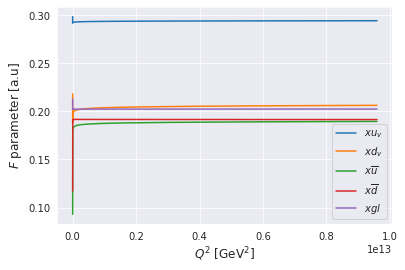

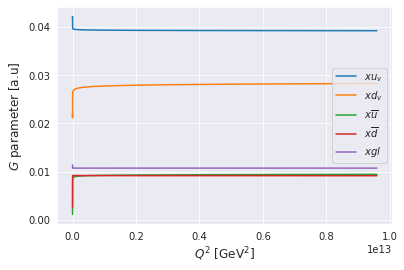

In [14]:
# in linear scale in x
for variable in variables:
    plt.figure()
    for i, pdfname in enumerate(pdfnames):
        x = fitted_betas[pdfname]['q_squared']
        y = fitted_betas[pdfname][variable]
        plt.plot(x, y, label=pdfnames_latex[i])#, s=3)
    plt.xlabel(r"$Q^2$ [GeV$^2$]", fontsize=12)  
    plt.ylabel("$"+variable+"$" + " parameter [a.u]", fontsize=12)
    #plt.xscale('log') 
    plt.legend()    
    plt.show()

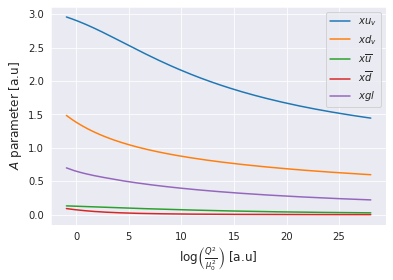

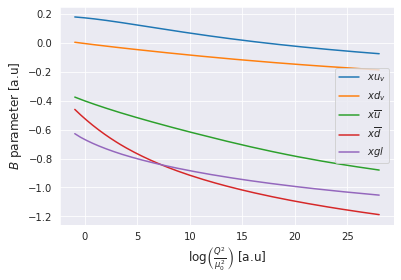

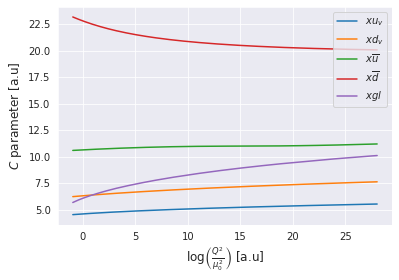

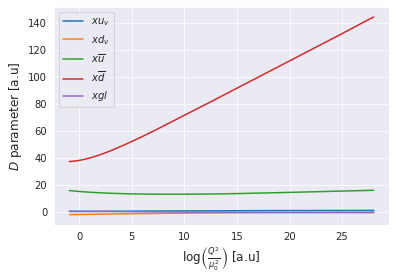

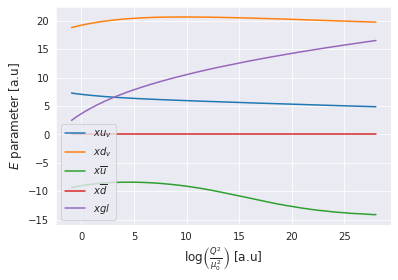

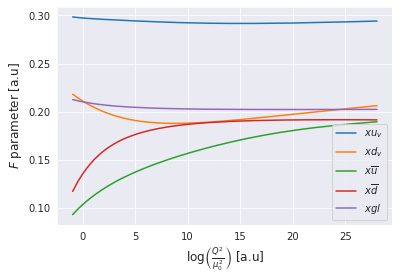

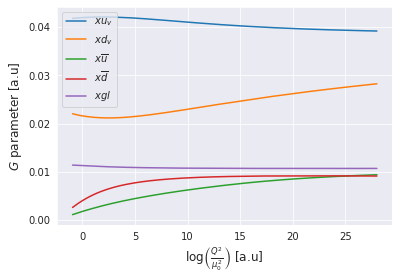

In [15]:
# in log scale in x
for variable in variables:
    plt.figure()
    for i, pdfname in enumerate(pdfnames):
        x = fitted_betas[pdfname]['q_squared']
        y = fitted_betas[pdfname][variable]
        x_log = np.log(x/2.56**2)
        plt.plot(x_log, y, label=pdfnames_latex[i])#, s=3)
    plt.xlabel(r"$\log{\left(\frac{Q^2}{\mu_0^2}\right)}$ [a.u]", fontsize=12)  # [GeV$^2$]
    plt.ylabel("$"+variable+"$" + " parameter [a.u]", fontsize=12)
    #plt.xscale('log') 
    plt.legend()    
    plt.show()

## Fits and plots of the parameters

In [16]:
def fit_graphics_parameters(x, y, y_fit, title, ylabel, xlabel, xscale, save, show):
    # figures
    fig, ax = plt.subplots(
        nrows=2,                                # set two horizontal axes
        figsize=(7,7),
        sharex=True,                            # x axis will be shared among all subplots.
        gridspec_kw={"height_ratios":[4,2]}     # different size for upper and bottom axes
    )
    
    # upper graph: the fits
    plt.sca(ax[0])                                    # set the current axes to axis=0
    plt.title(title, fontsize=20)
    plt.plot(x, y_fit, c='k', linestyle=(0,(5,5)), label="ODR fit")
    plt.plot(x, y_fit, c='k', linestyle=(0,(5,5)))
    plt.scatter(x, y, s=3)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()

    # bottom graph: the residuals
    plt.sca(ax[1])                                    # set the current axes to axis=1
    plt.scatter(x, y_fit-y, s=3)
    plt.xlabel(xlabel, fontsize=15)

    #fig.suptitle("Residuals")
    plt.xscale(xscale)
    plt.tight_layout()                                # 
    #plt.savefig(save)
    #plt.show() if show else plt.close()

In [17]:
def parameter_model(p, q2):
    return p[0] + p[1]*q2+ p[2]*q2**2 + p[3]*q2**3 + p[4]*q2**4 + p[5]*q2**5 + p[6]*q2**6 + p[7]*q2**7 + p[8]*q2**8 + p[9]*q2**9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
         ...     
0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
0   -1.667274e-08
Name: E, Length: 155, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

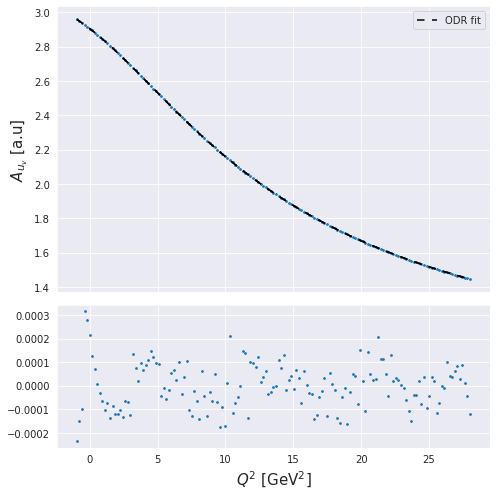

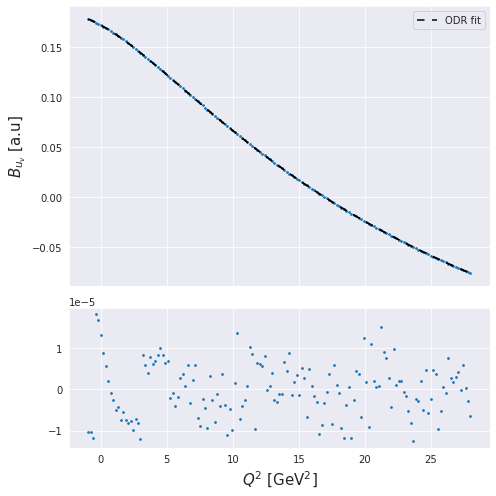

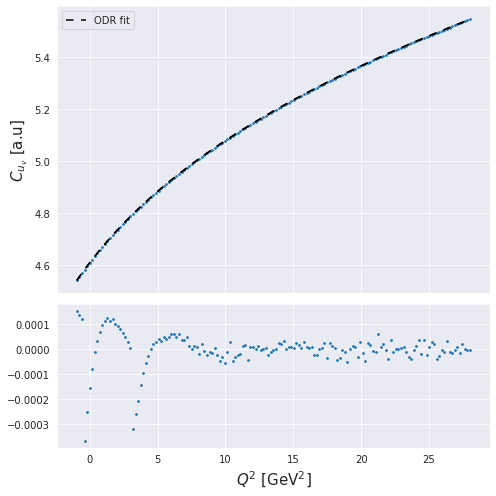

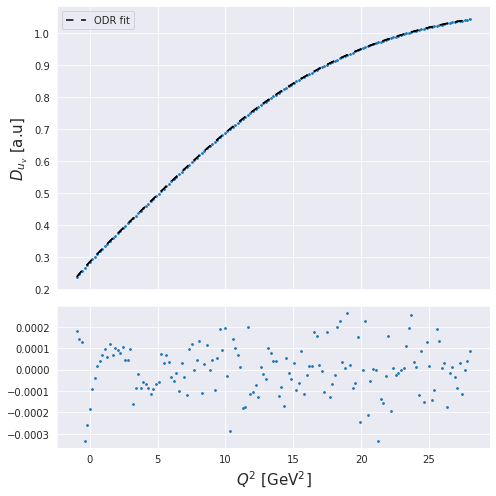

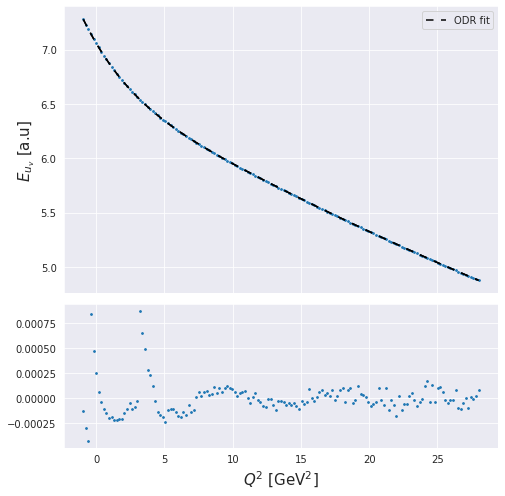

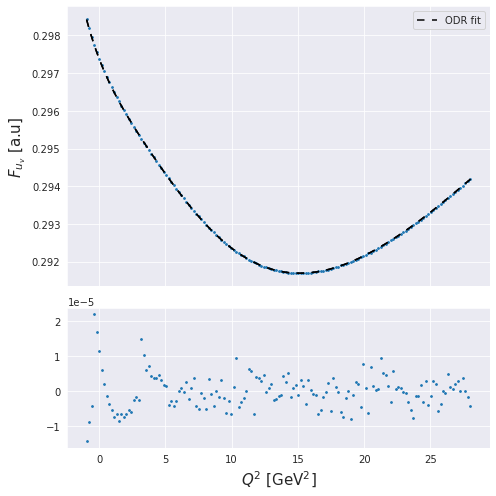

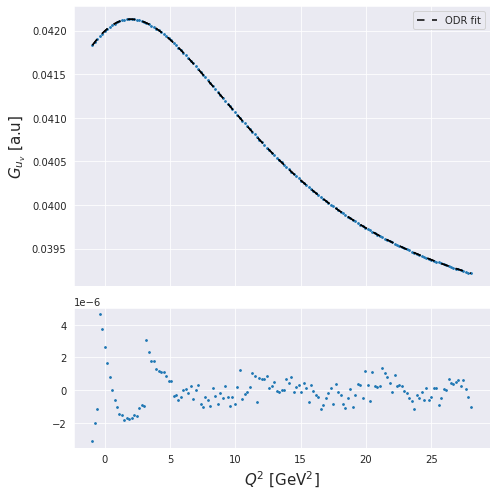

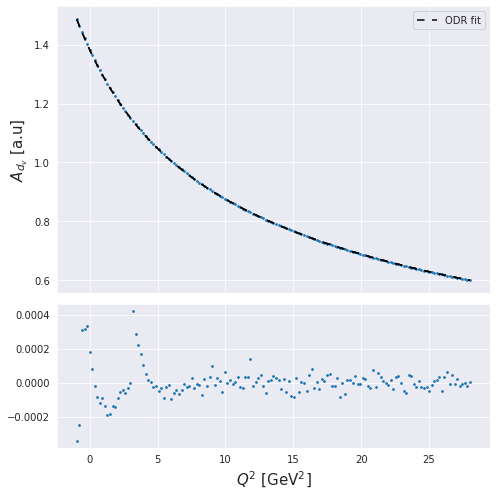

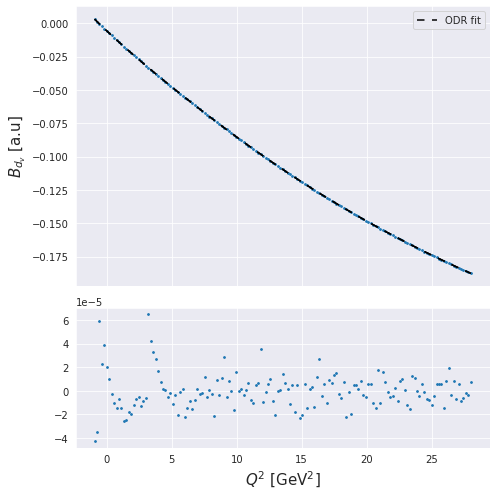

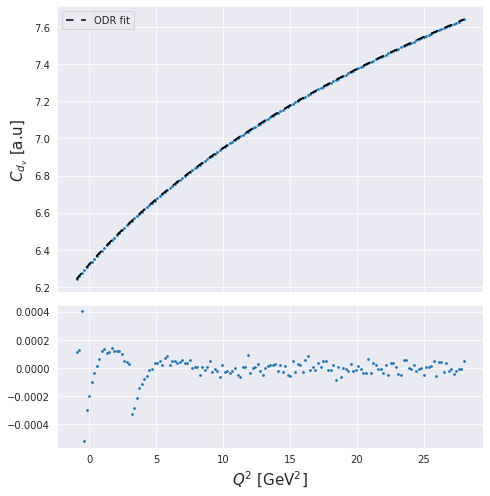

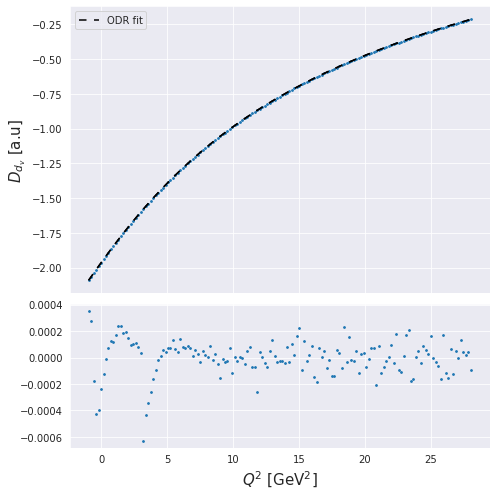

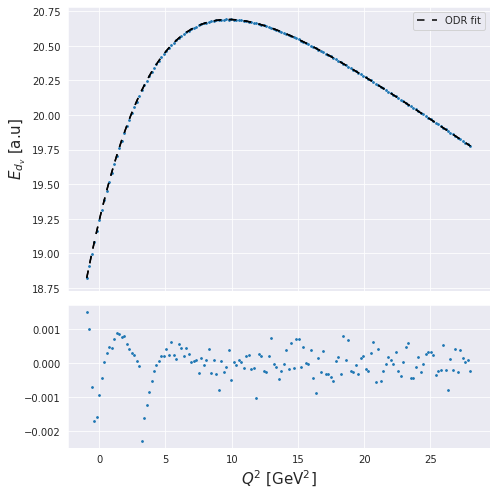

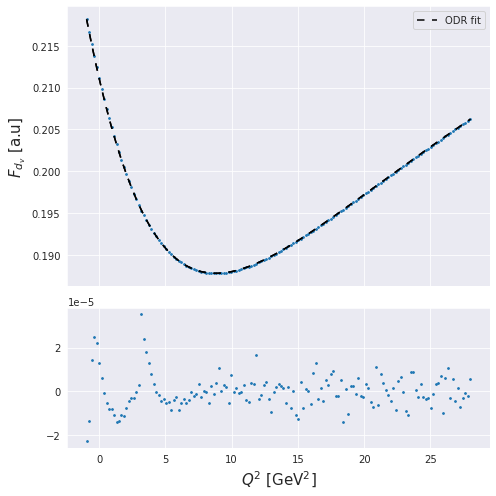

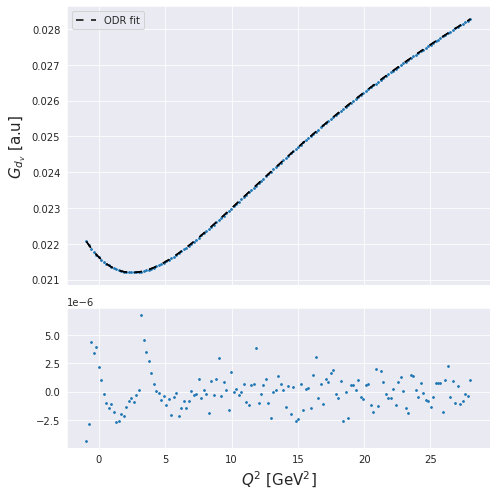

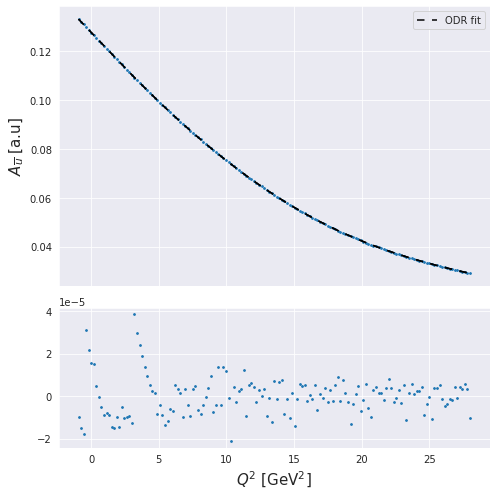

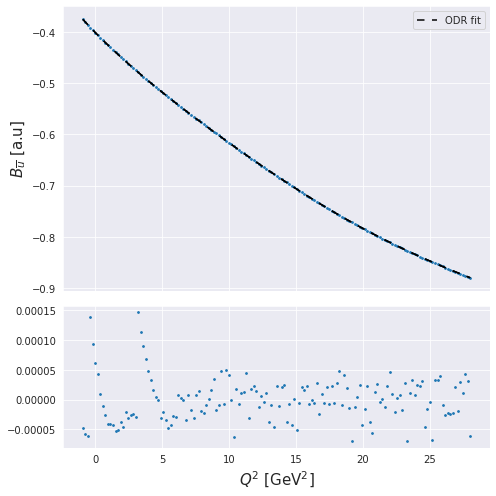

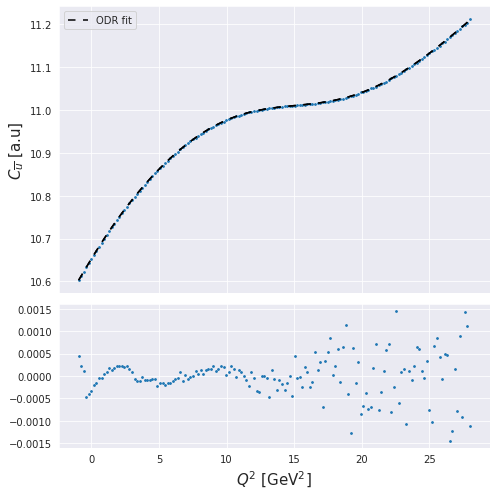

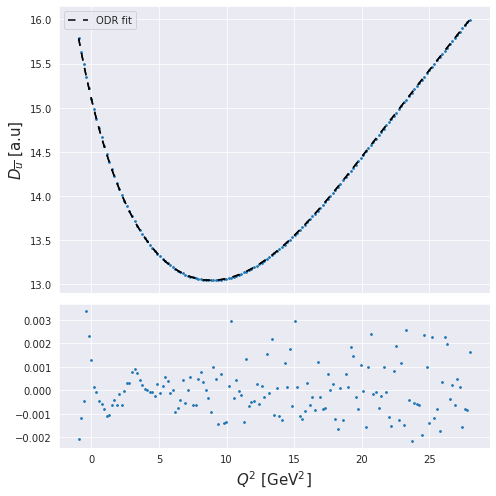

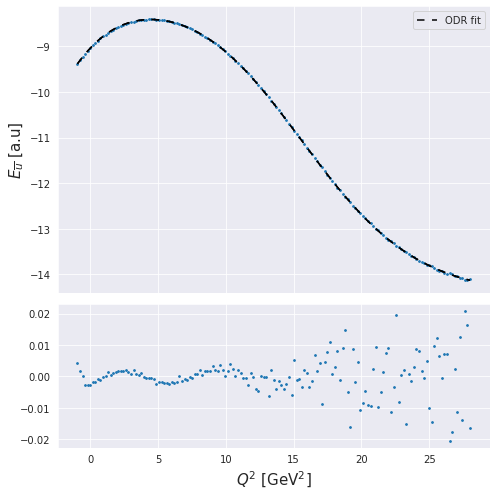

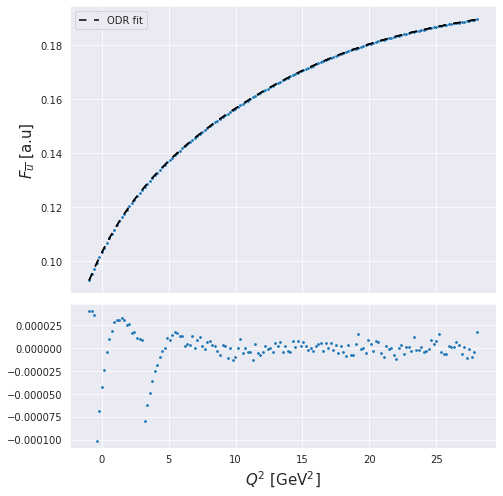

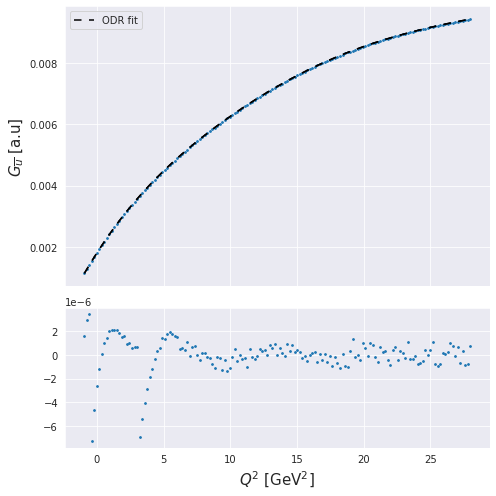

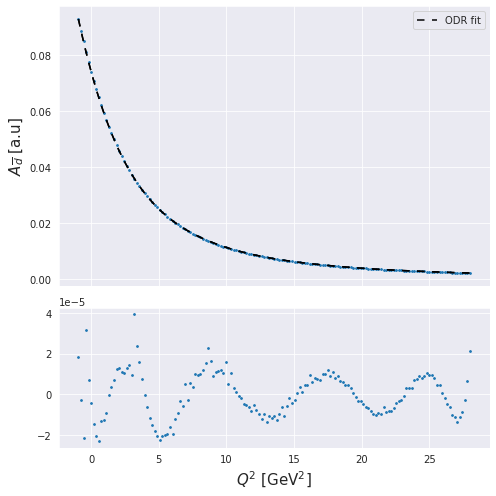

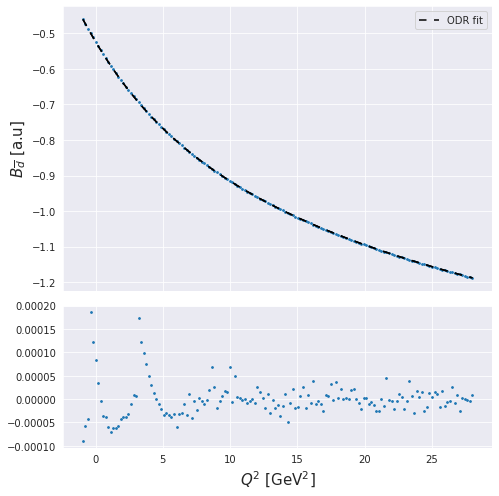

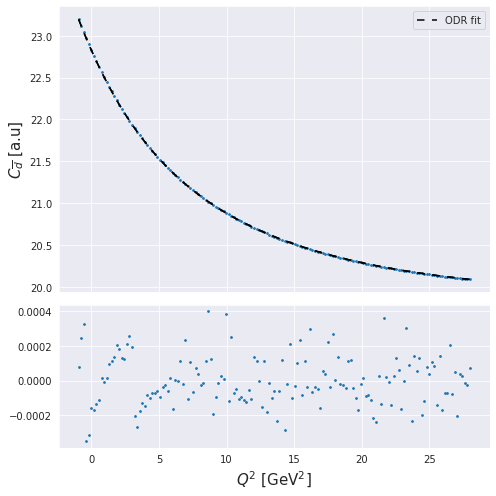

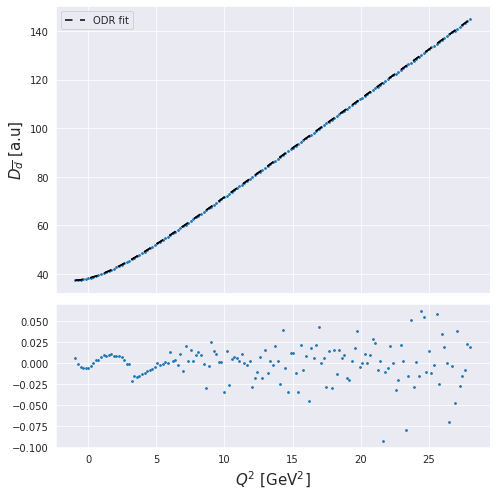

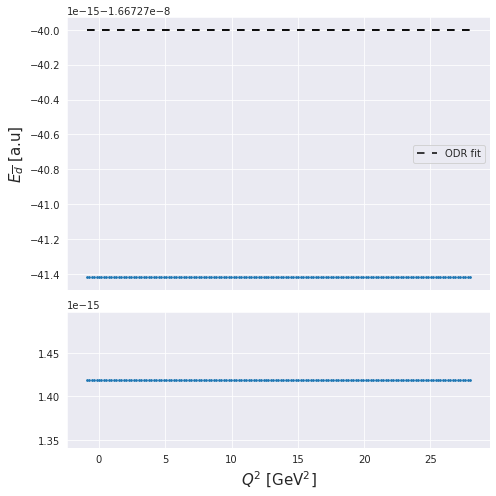

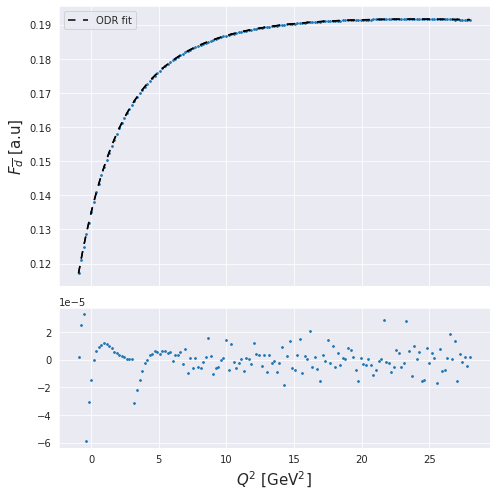

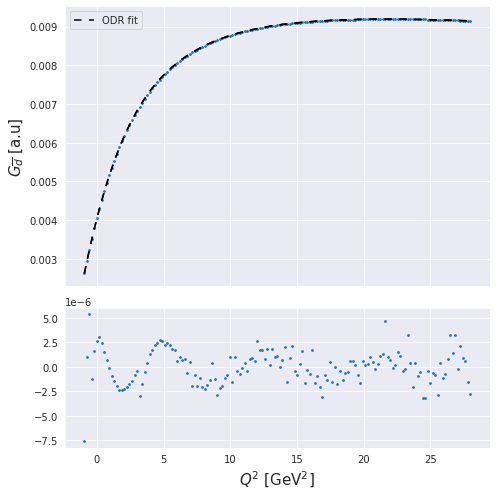

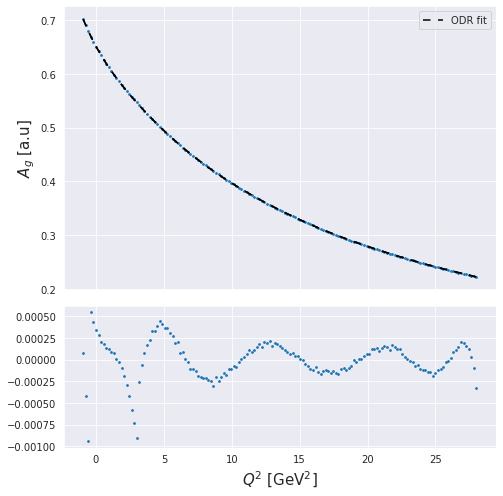

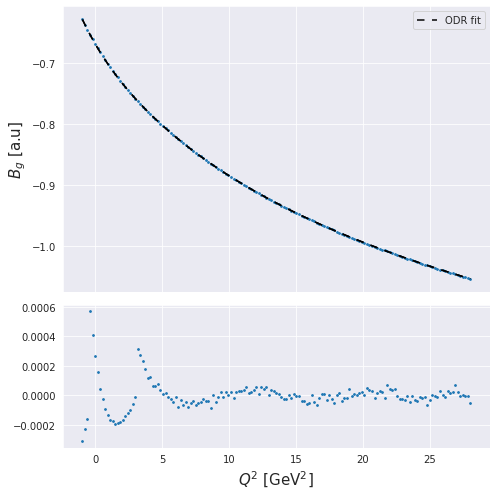

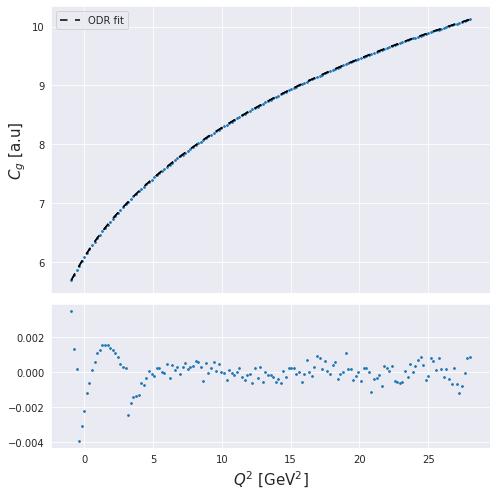

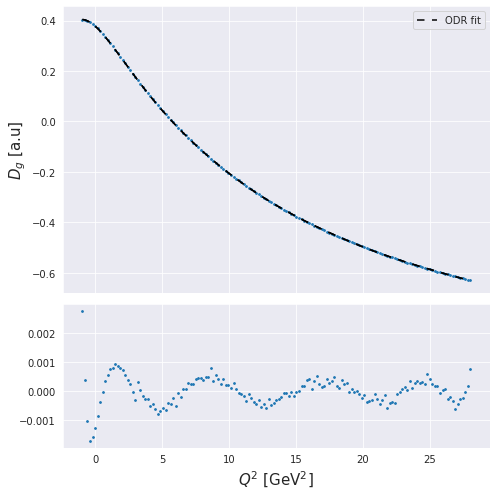

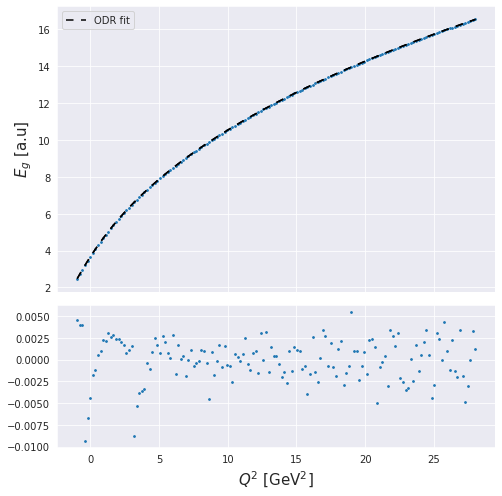

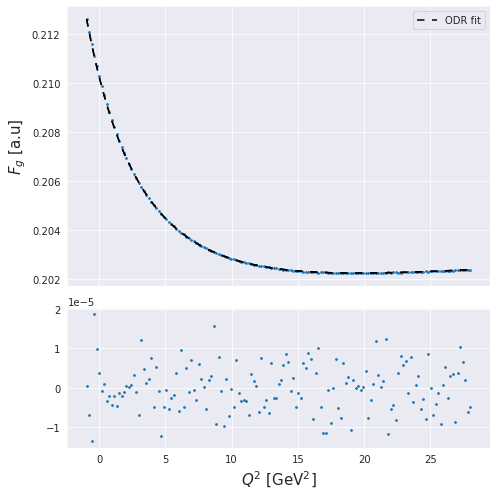

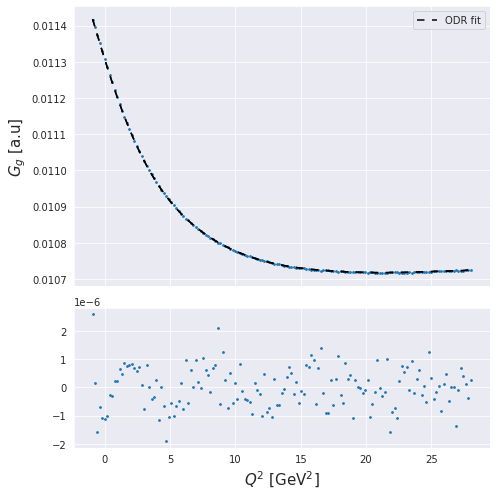

In [18]:
pdfnames_latex_2 = ['u_v', 'd_v', '\overline{u}', '\overline{d}', 'g']
betas_fit_pdf_for_parameters={}

for i, pdfname in enumerate(pdfnames):
    betas_fit_pdf_for_parameters[pdfname]={}
    # makes directories 
    os.makedirs(f"./img/{pdfname}/parameters", exist_ok=True)

    for parameter in variables:
        y=fitted_betas[pdfname][parameter]
        x=np.log(fitted_betas[pdfname]['q_squared']/2.56**2)
        initial_parameters1=[1,1,1,1,1,1,1,1,1,1]

        # fits the parameters as functions of Q^2
        fit=odr.ODR(odr.Data(x, y),
                    odr.Model(parameter_model),
                    beta0=initial_parameters1,
                    maxit=5000,
                    ).run()
        beta=fit.beta
        
        # makes the plots for every fitted parameter
        #if pdfname=="xubar": # debug de ubar
        save_name=f"./img/{pdfname}/parameters/{parameter}.png"

        if parameter=="E" and pdfname=="xdbar":
            arr = []
            print(y)
            for j in range(len(x)): arr.append(-1.667274e-08)
            fit_graphics_parameters(x,y, arr, "", "$"+parameter+"_{"+pdfnames_latex_2[i]+"}$ [a.u]",'$Q^2$ [GeV$^2$]','linear',save_name, False)
        else:
            fit_graphics_parameters(x,y, parameter_model(beta,x), "", "$"+parameter+"_{"+pdfnames_latex_2[i]+"}$ [a.u]",'$Q^2$ [GeV$^2$]','linear',save_name, False)
      
        betas_fit_pdf_for_parameters[pdfname][parameter]=beta

# Complete PDF functions: $xf$($x$, $Q^2$)
### Fitted PDF parametrizations, depending on $Q^2$ and $x$: 


In [19]:
def pdf_for_x_and_q_squared(x, q_squared, pdfname):
    parameters=[]
    # gets the fitted parameter
    for parameter in betas_fit_pdf_for_parameters[pdfname]:
        parameters.append(parameter_model(betas_fit_pdf_for_parameters[pdfname][parameter], np.log(q_squared/2.56**2)))
    return xpdf_model(parameters, x)

### Plot the complete PDFs in any $Q^2$ value.

In [20]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
cdict = {'red': ((0.0, 0.0, 0.0),   
                  (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
        'blue':  ((0.0, 1.0, 1.0),
                   (1.0, 0.0, 0.0))
        }
blue_green = LinearSegmentedColormap('BlueGreen', cdict, N=100)
cmap=plt.cm.get_cmap('RdBu')
norm = Normalize(np.log(min(filenames.keys())), np.log(max(filenames.keys())))

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


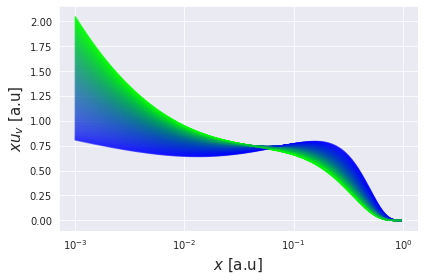

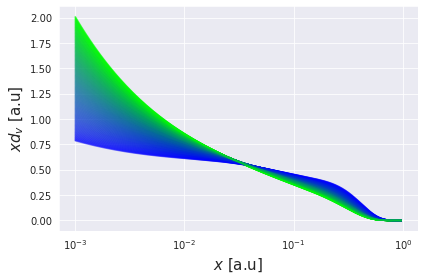

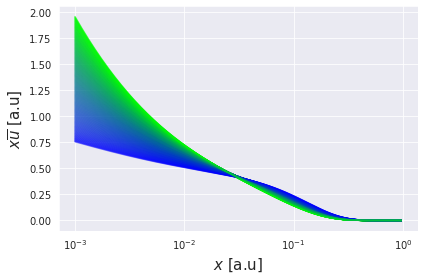

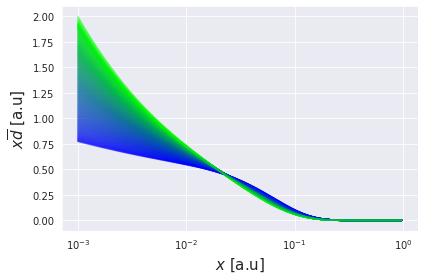

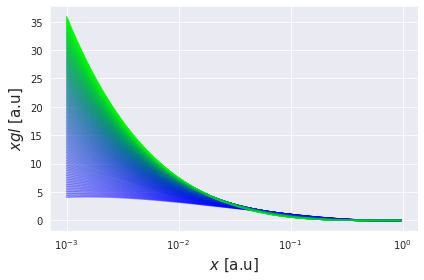

In [21]:
os.makedirs(f"./img/evolution", exist_ok=True)
x = pd.read_csv(filenames[2.56], sep=" ")['x']
for i, pdfname in enumerate(tqdm(pdfnames)):
    plt.figure()
    for q_squared in filenames.keys():
        y=pdf_for_x_and_q_squared(x,q_squared,pdfname)
        #if min(y)>=0:  # para quitar valores corruptos de xgl
        plt.plot(x,y,alpha=0.5,color=blue_green(norm(np.log(q_squared))))
        plt.ylabel(pdfnames_latex[i]+" [a.u]", fontsize=15)
    plt.xscale('log')
    plt.xlabel("$x$ [a.u]", fontsize=15)
    plt.tight_layout()
    plt.savefig(f"./img/evolution/{pdfname}.png")
    #files.download(f"./img/evolution/{pdfname}.png")  

# Total cross sections $\sigma\: (E_\nu)$

## $\nu N$ cross sections 

In [22]:
### Constants of the process (energies in GeV)
# masses in real units: GeV/c^2
M_Z = 91            # Z_0 boson mass
M_W = 80              # W boson mass
M_N = 0.938        # proton mass
G_F = 1.16632e-5    # Fermi constant [GeV^-2]
x_W = 0.226 

# for NC
L_u = 1 - 4/3*x_W
L_d = -1 + 2/3*x_W
R_u = -4/3 * x_W
R_d = 2/3*x_W

### Heavy quarks treatment

In [23]:
def pdf_sea_quark(x,q2):
    return pdf_for_x_and_q_squared(x,q2,'xdbar')

def function(x,q2):
    return ( pdf_for_x_and_q_squared(x,q2,'xuv')+pdf_for_x_and_q_squared(x,q2,'xdv') )/2 + ( pdf_for_x_and_q_squared(x,q2,'xubar') + pdf_for_x_and_q_squared(x,q2,'xdbar')  )/2 

def other_function(x,q2):
    return ( pdf_for_x_and_q_squared(x,q2,'xubar') + pdf_for_x_and_q_squared(x,q2,'xdbar') )/2

### CC and NC differential cross sections

We used the approximation $u_s=\overline{u}$, $\: d_s=\overline{d}$ and $s=\overline{d}$. 

In [24]:
def sec_diff_CC(x,y,E):
    q2=2*M_N*E*x*y
    return 2*G_F**2*M_N*E/np.pi*(M_W**2/(M_W**2 + q2))**2 * ( function(x,q2) + pdf_sea_quark(x,q2) + (1-y)**2 * other_function(x,q2) )

def sec_diff_NC(x,y,E):                        
    q2=2*M_N*E*x*y
    return G_F**2*M_N*E/(2*np.pi)*(M_W**2/(M_W**2 + q2))**2 * ( function(x,q2)*(L_u**2 +L_d**2) +  other_function(x,q2)*(R_u**2 +R_d**2) + pdf_sea_quark(x,q2)*(L_d**2 +R_d**2)
                                                               + (1-y)**2 * (  function(x,q2)*(R_u**2 +R_d**2) +  other_function(x,q2)*(L_u**2 +L_d**2) + pdf_sea_quark(x,q2)*(L_u**2 +R_u**2)  ) )

100%|██████████| 11/11 [09:02<00:00, 49.30s/it] 


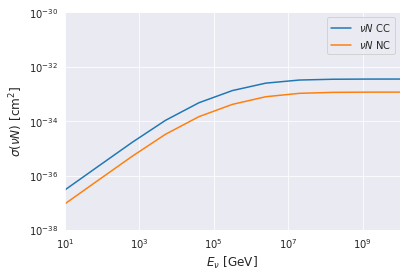

In [28]:
energies = []
cross_sections_CC = []
cross_sections_NC = []

for E in tqdm(np.logspace(1, 10, 11)):  
    integral_CC = integrate.nquad(lambda x,y, E=E: sec_diff_CC(x,y,E),[[1e-3, 1], [0, 1]], full_output=True)
    integral_NC = integrate.nquad(lambda x,y, E=E: sec_diff_NC(x,y,E),[[1e-3, 1], [0, 1]], full_output=True)
    energies.append(E)
    cross_sections_CC.append(integral_CC[0]*10**(-27))
    cross_sections_NC.append(integral_NC[0]*10**(-27))
    
plt.plot(energies, cross_sections_CC, label=r"$\nu N$ CC")
plt.plot(energies, cross_sections_NC, label=r"$\nu N$ NC")
plt.ylim(1e-38,1e-30)
plt.xlim(1e1,1e10)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\sigma (\nu N)$ [cm$^{2}$]", fontsize=12)
plt.xlabel(r"$E_\nu$ [GeV]", fontsize=12)
plt.legend()
plt.savefig("cross_sections_neutrino.png")

## $\overline{\nu} N$ cross sections

In [29]:
# other function es function y viceversa
def sec_diff_CC_antineutrino(x,y,E):
    q2=2*M_N*E*x*y
    return 2*G_F**2*M_N*E/np.pi*(M_W**2/(M_W**2 + q2))**2 * ( other_function(x,q2) + pdf_sea_quark(x,q2) + (1-y)**2 * function(x,q2) )

def sec_diff_NC_antineutrino(x,y,E):                        
    q2=2*M_N*E*x*y
    return G_F**2*M_N*E/(2*np.pi)*(M_W**2/(M_W**2 + q2))**2 * ( other_function(x,q2)*(L_u**2 +L_d**2) +  function(x,q2)*(R_u**2 +R_d**2) + pdf_sea_quark(x,q2)*(L_d**2 +R_d**2)
                                                               + (1-y)**2 * (  other_function(x,q2)*(R_u**2 +R_d**2) +  function(x,q2)*(L_u**2 +L_d**2) + pdf_sea_quark(x,q2)*(L_u**2 +R_u**2)  ) )

100%|██████████| 11/11 [08:54<00:00, 48.60s/it] 


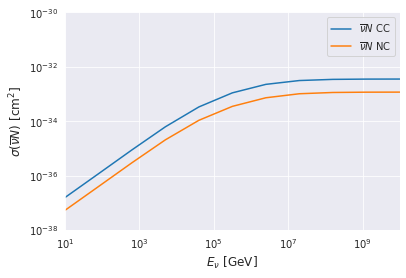

In [30]:
energies = []
cross_sections_CC = []
cross_sections_NC = []

for E in tqdm(np.logspace(1, 10, 11)):  
    integral_CC = integrate.nquad(lambda x,y, E=E: sec_diff_CC_antineutrino(x,y,E),[[1e-3, 1], [0, 1]], full_output=True)
    integral_NC = integrate.nquad(lambda x,y, E=E: sec_diff_NC_antineutrino(x,y,E),[[1e-3, 1], [0, 1]], full_output=True)
    energies.append(E)
    cross_sections_CC.append(integral_CC[0]*10**(-27))
    cross_sections_NC.append(integral_NC[0]*10**(-27))
    
plt.plot(energies, cross_sections_CC, label=r"$\overline{\nu} N$ CC")
plt.plot(energies, cross_sections_NC, label=r"$\overline{\nu} N$ NC")
plt.ylim(1e-38,1e-30)
plt.xlim(1e1,1e10)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\sigma (\overline{\nu} N)$ [cm$^{2}$]", fontsize=12)
plt.xlabel(r"$E_\nu$ [GeV]", fontsize=12)
plt.legend()
plt.savefig("cross_sections_antineutrino.png")